In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
from autograd.tensor.engine import Tensor
from autograd.tensor.nn import MLP, CrossEntropyLoss

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
np.random.seed(1337)
random.seed(1337)

In [53]:
import numpy as np
import struct


def load_images(path):
    with open(path, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num, rows * cols)
        return images.astype(np.float32) / 255.0  # normalize


def load_labels(path):
    with open(path, "rb") as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

In [54]:
X_train = load_images("../data/train-images.idx3-ubyte")
y_train = load_labels("../data/train-labels.idx1-ubyte")

X_test = load_images("../data/t10k-images.idx3-ubyte")
y_test = load_labels("../data/t10k-labels.idx1-ubyte")

print(X_train.shape)  # (60000, 784)
print(y_train.shape)  # (60000,)

(60000, 784)
(60000,)


In [63]:
# Initialize a model 
model = MLP(784, [256, 256, 256, 10])
print(model)
print("Number of parameters", sum(p.data.size for p in model.parameters()))


Sequential(
  (0): Linear(in=784, out=256)
  (1): ReLU()
  (2): Linear(in=256, out=256)
  (3): ReLU()
  (4): Linear(in=256, out=256)
  (5): ReLU()
  (6): Linear(in=256, out=10)
)
Number of parameters 335114


In [65]:
# Training loop (PyTorch-style)
batch_size = 256
num_epochs = 500
learning_rate = 0.1

criterion = CrossEntropyLoss()
train_losses = []
train_accs = []

for epoch in range(num_epochs):

    # Sample a batch
    if batch_size is None:
        Xb, yb = X_train, y_train
    else:
        ri = np.random.permutation(X_train.shape[0])[:batch_size]
        Xb, yb = X_train[ri], y_train[ri]

    # Convert batch to a single Tensor (batch_size, in_features)
    inputs = Tensor(Xb)

    # Forward pass — model outputs shape (batch_size, num_classes)
    logits = model(inputs)

    # Compute cross-entropy loss
    loss = criterion(logits, yb)

    # L2 regularization
    lambda_reg = 1e-4
    l2_reg = sum(
        (p * p).sum() for p in model.parameters()
    )
    total_loss = loss + lambda_reg * l2_reg

    # Compute accuracy (numpy, no grad needed)
    preds = np.argmax(logits.data, axis=1)
    acc = (preds == yb).mean()

    # Zero gradients
    model.zero_grad()

    # Backward pass
    total_loss.backward()

    # Update weights (SGD with linear LR decay)
    lr = learning_rate - 0.9 * learning_rate * epoch / num_epochs
    for p in model.parameters():
        p.data -= lr * p.grad

    # Record metrics
    train_losses.append(float(total_loss.data))
    train_accs.append(float(acc))

    # Log progress
    if epoch % 1 == 0:
        print(f"Epoch {epoch:3d} | Loss: {total_loss.data:.4f} | Accuracy: {acc*100:.2f}%")


Epoch   0 | Loss: 0.4436 | Accuracy: 96.88%
Epoch   1 | Loss: 0.4646 | Accuracy: 95.70%
Epoch   2 | Loss: 0.5004 | Accuracy: 95.31%
Epoch   3 | Loss: 0.4778 | Accuracy: 96.09%
Epoch   4 | Loss: 0.4565 | Accuracy: 96.09%
Epoch   5 | Loss: 0.4250 | Accuracy: 97.66%
Epoch   6 | Loss: 0.4583 | Accuracy: 96.09%
Epoch   7 | Loss: 0.5630 | Accuracy: 94.92%
Epoch   8 | Loss: 0.5085 | Accuracy: 94.14%
Epoch   9 | Loss: 0.5085 | Accuracy: 95.31%
Epoch  10 | Loss: 0.5218 | Accuracy: 93.75%
Epoch  11 | Loss: 0.4938 | Accuracy: 93.75%
Epoch  12 | Loss: 0.4327 | Accuracy: 96.88%
Epoch  13 | Loss: 0.5113 | Accuracy: 95.31%
Epoch  14 | Loss: 0.4270 | Accuracy: 96.48%
Epoch  15 | Loss: 0.4321 | Accuracy: 95.31%
Epoch  16 | Loss: 0.4530 | Accuracy: 96.88%
Epoch  17 | Loss: 0.5188 | Accuracy: 92.58%
Epoch  18 | Loss: 0.4796 | Accuracy: 96.09%
Epoch  19 | Loss: 0.4323 | Accuracy: 97.27%
Epoch  20 | Loss: 0.5153 | Accuracy: 94.92%
Epoch  21 | Loss: 0.5312 | Accuracy: 93.75%
Epoch  22 | Loss: 0.4905 | Accur

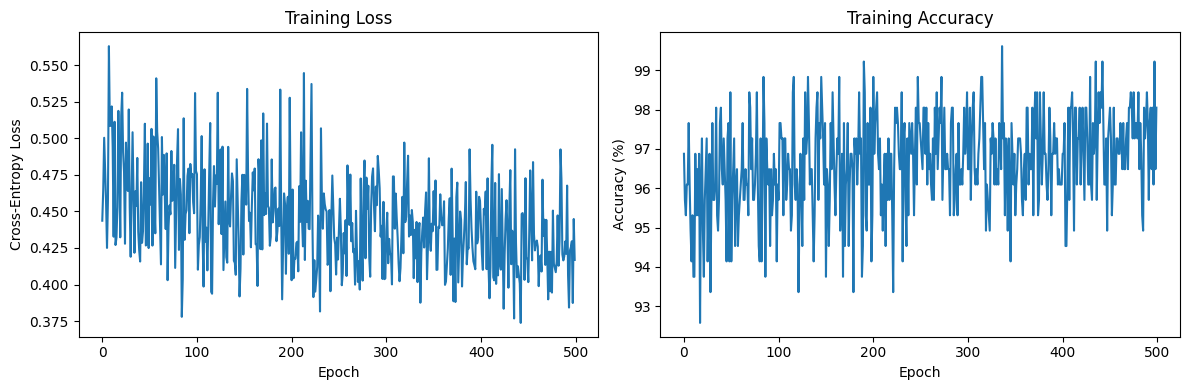

In [66]:
# Plot training loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cross-Entropy Loss")

ax2.plot([a * 100 for a in train_accs])
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()


Test Accuracy: 96.24%


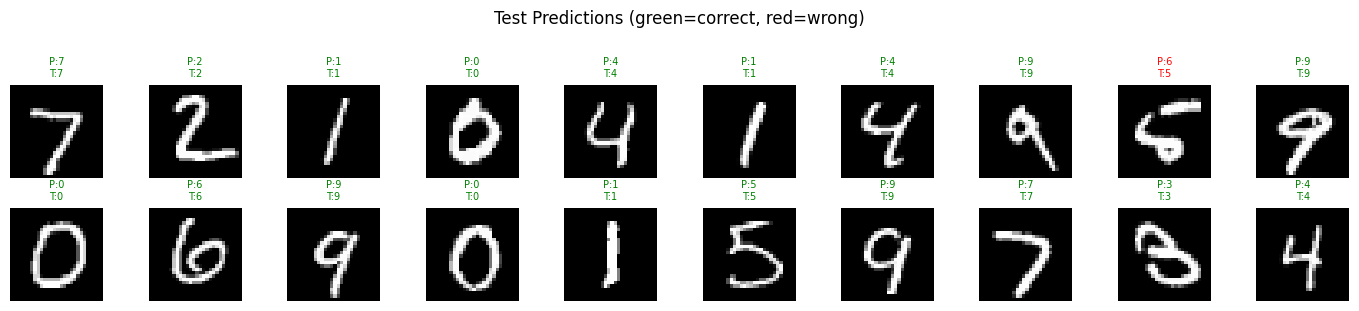

In [67]:
# Evaluate on test set
test_inputs = Tensor(X_test, requires_grad=False)
test_logits = model(test_inputs)
test_preds = np.argmax(test_logits.data, axis=1)
test_acc = (test_preds == y_test).mean()
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Show a few predictions
fig, axes = plt.subplots(2, 10, figsize=(14, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    color = 'green' if test_preds[i] == y_test[i] else 'red'
    ax.set_title(f"P:{test_preds[i]}\nT:{y_test[i]}", fontsize=7, color=color)
    ax.axis('off')
plt.suptitle("Test Predictions (green=correct, red=wrong)", y=1.02)
plt.tight_layout()
plt.show()
